In [23]:
import os
import shutil

import math
import numpy as np
import pandas as pd

from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import imageio

%matplotlib inline

# Work description

## Problem Statement

Developed an algorithm to localize a car equipped with wheel encoders and a lobal navigation satellite system (GNSS) receiver. 
The wheel encoders provide linear and angular speed information, while the GNSS provides position information. 

<img src="./frames.jpg" width=500/>

The following assumptions are made:
- The sensors are mounted in the center of the rear axle of the car.
- The car is moving on a 2D plane.
- The position is expressed in the ``map`` frame. The ``map`` and ``odom`` frames are identical in our scenario.
- The measurements are affected by some noise, the estimated covariances of which are provided.

The expected output of the algorithm is the following:
- Estimated position and orientation of the car in the ``map`` frame.

## Understand Data

First, we have to load data and get acquainted with the scenario. We use CSV data instead of the rosbag to not introduce further ROS-related dependencies in the conda environment if avoidable.

Scenario:
- The sensors are mounted in the center of the rear axle of the car.
- The car is moving on a 2D plane.
- The position is expressed in the ``map`` frame. The ``map`` and ``odom`` frames are identical in our scenario.
- The measurements are affected by some noise, the estimated covariances of which are provided.



### Global Navigation Satellite System (GNSS)

``data/gnss.csv`` stores the GNSS 2D position measurements of the car in the ``map`` frame. The estimated standard deviation on the measurements is 0.7 m.

In [2]:
gnss_df = pd.read_csv("data/gnss.csv")
gnss_df.loc[:, "time"] = pd.to_datetime(gnss_df["time"])
gnss_df

,time,position_x,position_y
0,2021-07-30 15:52:26.253290,-10.924823,10.823307
1,2021-07-30 15:52:26.354880,-11.567214,11.685904
2,2021-07-30 15:52:26.453560,-10.588920,11.858020
3,2021-07-30 15:52:26.553600,-10.549690,8.442866
4,2021-07-30 15:52:26.653610,-9.820674,10.442212
...,...,...,...
1101,2021-07-30 15:54:16.356960,-2.051479,8.560521
1102,2021-07-30 15:54:16.458670,-2.436100,9.047826
1103,2021-07-30 15:54:16.556130,-0.669257,8.393341
1104,2021-07-30 15:54:16.657770,-2.176093,10.220617


1-D Plot:

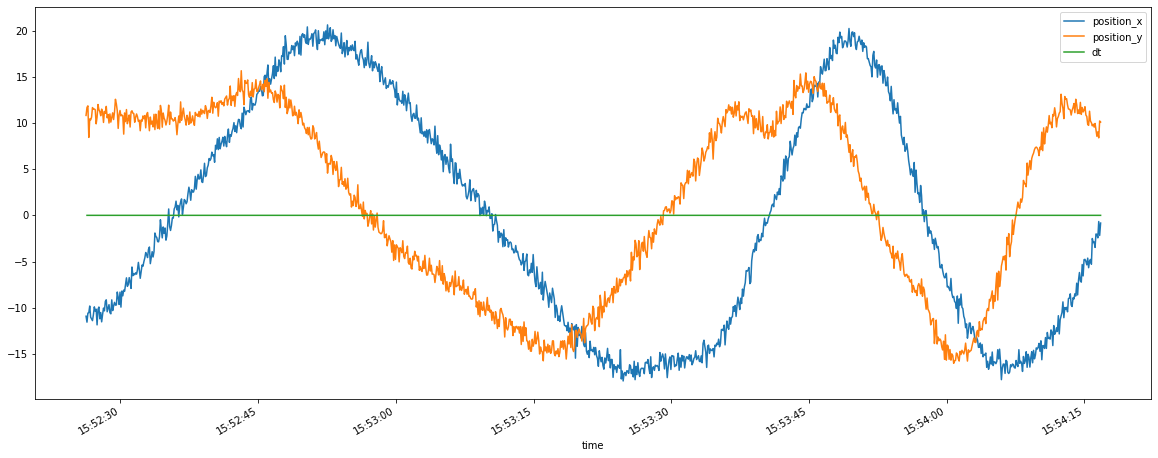

In [25]:
gnss_df.set_index("time").plot(figsize=(20,8));

2-D Plot:

<AxesSubplot:xlabel='position_x'>

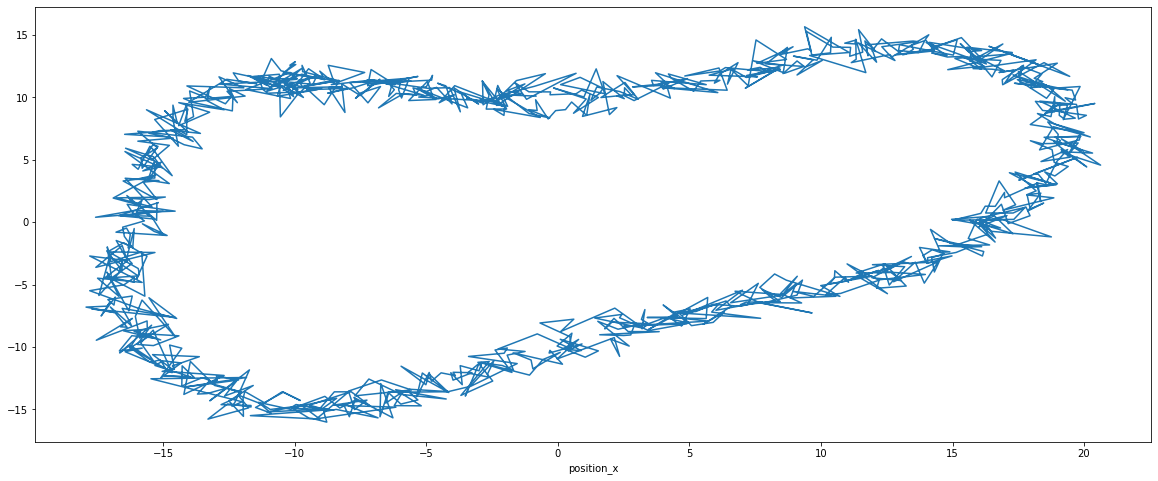

In [26]:
gnss_df.set_index("position_x")["position_y"].plot(figsize=(20,8))

### Odometry

``/sensors/odom`` stores linear and angular speed measurements of the car with respect to the ``odom`` frame, in the frame of the car (``x`` axis pointing forward, ``y`` axis pointing left)

In [27]:
odom_df = pd.read_csv("data/odom.csv")
odom_df.loc[:, "time"] = pd.to_datetime(odom_df["time"])
odom_df

,time,linear_x,linear_y,angular_z,cov_linear_x,cov_linear_y,cov_angular_z
0,2021-07-30 15:52:26.179530,0.000000,0,0.000000,0.000000,0.000000,0.000000
1,2021-07-30 15:52:26.193150,0.000000,0,0.000000,0.000000,0.000000,0.000000
2,2021-07-30 15:52:26.212260,0.000000,0,0.000000,0.000000,0.000000,0.000000
3,2021-07-30 15:52:26.231900,0.000000,0,0.000000,0.000000,0.000000,0.000000
4,2021-07-30 15:52:26.278810,0.000000,0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
5523,2021-07-30 15:54:16.663310,2.056655,0,0.384702,0.629169,0.079771,0.031778
5524,2021-07-30 15:54:16.708350,3.326010,0,0.427850,0.625476,0.080035,0.031808
5525,2021-07-30 15:54:16.730250,1.069632,0,0.185421,0.621888,0.080600,0.031876
5526,2021-07-30 15:54:16.771300,1.891994,0,0.390299,0.616866,0.081654,0.032010


1-D Plot:

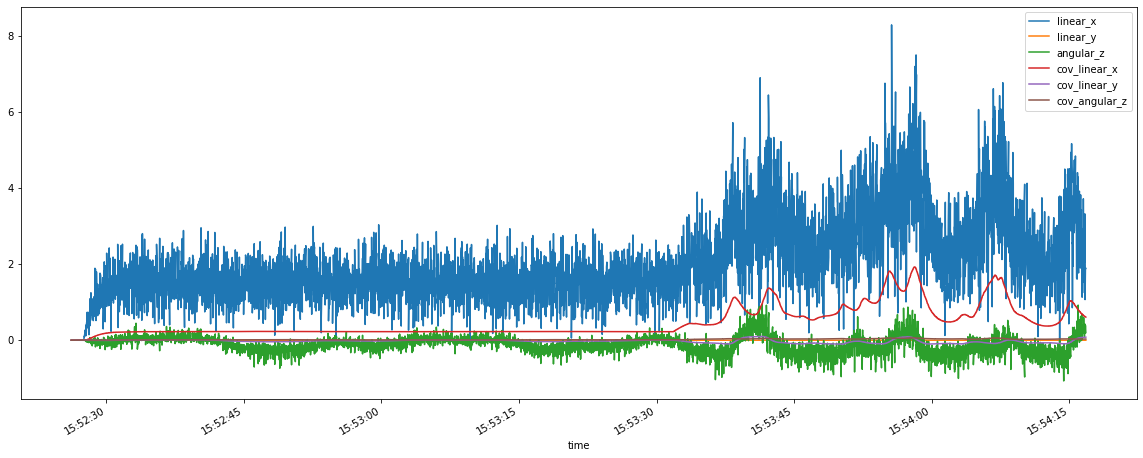

In [34]:
odom_df.set_index("time").plot(figsize=(20,8));

### Ground Truth (for algorithm validation)

``data/ground_truth.csv`` stores the true position and speed of the car, given for reference. The orientation is expressed as a quaternion. The speed is given with respect to the ``odom`` frame, in the frame of the car.

In [29]:
ground_truth_df = pd.read_csv("data/ground_truth.csv")
ground_truth_df.loc[:, "time"] = pd.to_datetime(ground_truth_df["time"])
ground_truth_df

,time,position_x,position_y,orientation_x,orientation_y,orientation_z,orientation_w,speed_x,speed_y,angular_z
0,2021-07-30 15:52:26.179230,-11.000000,11.000000,0,0,0.000000,1.000000,0.000000,0,0.000000
1,2021-07-30 15:52:26.191630,-11.000000,11.000000,0,0,0.000000,1.000000,0.000000,0,0.000000
2,2021-07-30 15:52:26.212240,-11.000000,11.000000,0,0,0.000000,1.000000,0.000000,0,0.000000
3,2021-07-30 15:52:26.231880,-11.000000,11.000000,0,0,0.000000,1.000000,0.000000,0,0.000000
4,2021-07-30 15:52:26.276780,-11.000000,11.000000,0,0,0.000000,1.000000,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...
5524,2021-07-30 15:54:16.657780,-1.496539,9.286918,0,0,-0.125610,0.992080,2.493555,0,0.314104
5525,2021-07-30 15:54:16.699280,-1.448490,9.274552,0,0,-0.122489,0.992470,2.486214,0,0.316152
5526,2021-07-30 15:54:16.745270,-1.379725,9.257316,0,0,-0.117986,0.993015,2.475903,0,0.318133
5527,2021-07-30 15:54:16.787270,-1.261319,9.228776,0,0,-0.110145,0.993916,2.458621,0,0.320891


1-D Plot:

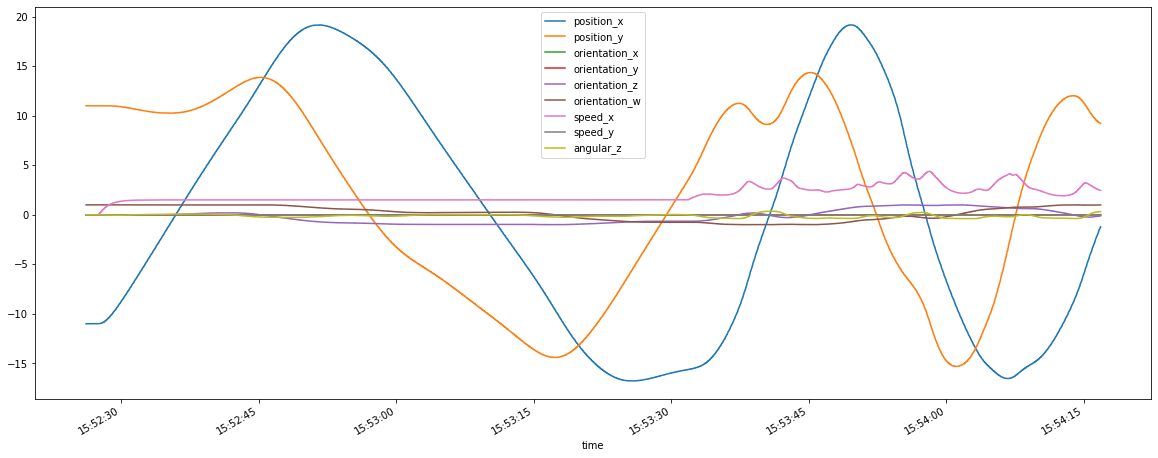

In [33]:
ground_truth_df.set_index("time").plot(figsize=(20,8));

2-D Plot:

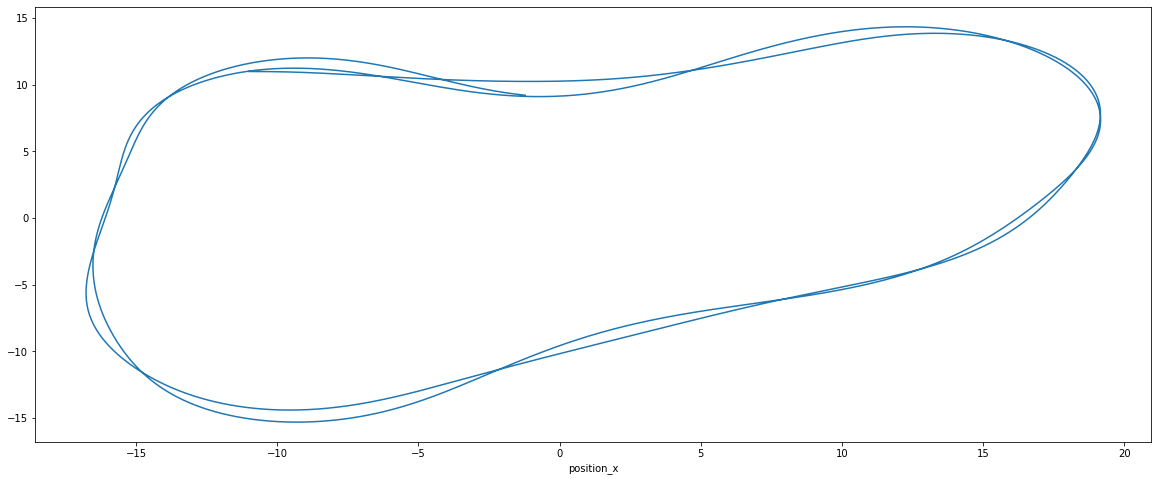

In [32]:
ground_truth_df.set_index("position_x")["position_y"].plot(figsize=(20,8));

GNSS vs Ground Truth 2-D plot:

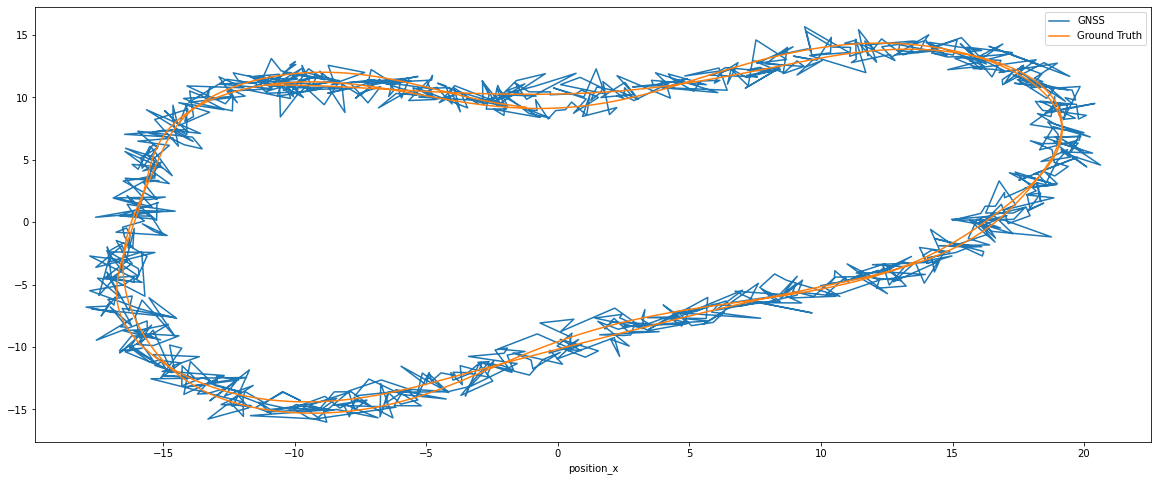

In [36]:
fig, ax = plt.subplots(figsize=(20,8))
gnss_df.set_index("position_x")["position_y"].rename("GNSS").plot(ax = ax, legend=True,)
ground_truth_df.set_index("position_x")["position_y"].rename("Ground Truth").plot(ax=ax, legend=True);

### Time delta



In [11]:
gnss_df['dt'] = gnss_df['time'].diff(1).dt.total_seconds().div(60)
print(gnss_df["dt"].mean())
gnss_df

0.0016667588235294104


,time,position_x,position_y,dt
0,2021-07-30 15:52:26.253290,-10.924823,10.823307,NaN
1,2021-07-30 15:52:26.354880,-11.567214,11.685904,0.001693
2,2021-07-30 15:52:26.453560,-10.588920,11.858020,0.001645
3,2021-07-30 15:52:26.553600,-10.549690,8.442866,0.001667
4,2021-07-30 15:52:26.653610,-9.820674,10.442212,0.001667
...,...,...,...,...
1101,2021-07-30 15:54:16.356960,-2.051479,8.560521,0.001714
1102,2021-07-30 15:54:16.458670,-2.436100,9.047826,0.001695
1103,2021-07-30 15:54:16.556130,-0.669257,8.393341,0.001624
1104,2021-07-30 15:54:16.657770,-2.176093,10.220617,0.001694


In [12]:
odom_df['dt'] = odom_df['time'].diff(1).dt.total_seconds().div(60)
print(odom_df["dt"].mean())
odom_df

0.00033362429889633626


,time,linear_x,linear_y,angular_z,cov_linear_x,cov_linear_y,cov_angular_z,dt
0,2021-07-30 15:52:26.179530,0.000000,0,0.000000,0.000000,0.000000,0.000000,NaN
1,2021-07-30 15:52:26.193150,0.000000,0,0.000000,0.000000,0.000000,0.000000,2.270000e-04
2,2021-07-30 15:52:26.212260,0.000000,0,0.000000,0.000000,0.000000,0.000000,3.185000e-04
3,2021-07-30 15:52:26.231900,0.000000,0,0.000000,0.000000,0.000000,0.000000,3.273333e-04
4,2021-07-30 15:52:26.278810,0.000000,0,0.000000,0.000000,0.000000,0.000000,7.818333e-04
...,...,...,...,...,...,...,...,...
5523,2021-07-30 15:54:16.663310,2.056655,0,0.384702,0.629169,0.079771,0.031778,1.666667e-07
5524,2021-07-30 15:54:16.708350,3.326010,0,0.427850,0.625476,0.080035,0.031808,7.506667e-04
5525,2021-07-30 15:54:16.730250,1.069632,0,0.185421,0.621888,0.080600,0.031876,3.650000e-04
5526,2021-07-30 15:54:16.771300,1.891994,0,0.390299,0.616866,0.081654,0.032010,6.841667e-04


### Conclusion

This looks like a classical localization problem which can be solved by using a [Kalman filter](https://en.wikipedia.org/wiki/Kalman_filter)

## Kalman Filter

The Kalman filter was invented by Rudolf Emil Kálmán to address noisy sensors problem in a mathematically optimal way. It is an algorithm that uses a series of measurements observed over time, including statistical noise and other inaccuracies, and produces estimates of unknown variables that tend to be more accurate than those based on a single measurement alone, by estimating a joint probability distribution over the variables for each timeframe:


**Initialization**

    1. Initialize the state of the filter
    2. Initialize our belief in the state
    
**Predict**

    1. Use process model to predict state at the next time step
    2. Adjust belief to account for the uncertainty in prediction    
**Update**

    1. Get a measurement and associated belief about its accuracy
    2. Compute residual between estimated state and measurement
    3. Compute scaling factor based on whether the measurement
    or prediction is more accurate
    4. set state between the prediction and measurement based 
    on scaling factor
    5. update belief in the state based on how certain we are 
    in the measurement
   
<br>
<br>

<img src="./kalman.jpg" width=600/>



## Predict Step

For the prediction we need to design the state and covariance, the process model and the process noise.

### Motion model

For simplicity's sake, we model our car as a unicycle:

<img src="./unicycle_model.png" width=300/>

$$
\begin{cases}
\dot{x} = v \cos(\theta)\\
\dot{y} = v \sin(\theta)\\
\omega = \dot{\theta} \\
\end{cases}
$$

The prediction equations are:

$$
\begin{cases}
\bar{x} = x +  v \cos(\theta) \Delta t\\
\bar{y} = y + v \sin(\theta) \Delta t\\
\bar{\theta} = \theta + \dot{\theta} \Delta t \\
\end{cases}
$$

Our motion model is **nonlinear**, and we will need an Extended Kalman filter.

The car has a state vector includes 3 states at time $t$.

$$\textbf{x}_t=[x_t, y_t, \theta_t]$$

$x_t$, $y_t$ are a 2D x-y position, and $\theta_t$ is the orientation. In a matrix form:

$$ \textbf{x}_{t+1} = F\textbf{x}_t+B\textbf{u}_t $$

where

$$
F= \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix} 
\quad 
\quad 
B= \begin{bmatrix} cos(\theta)dt & 0\\ sin(\theta)dt & 0\\ 0 & dt\\ \end{bmatrix}
\quad
\quad
dt \text{ is a time interval}
$$

In [13]:
def motion_model(x, u, dt):
    F = np.array([
        [1.0, 0, 0],
        [0, 1.0, 0],
        [0, 0, 1.0],
    ])
    B = np.array([
        [dt * math.cos(x[2, 0]), 0],
        [dt * math.sin(x[2, 0]), 0],
        [0.0, dt],
    ])
    x = F @ x + B @ u
    return x

Its Jacobian matrix is

$$
J_F
=
\begin{bmatrix}
    \frac{dx}{dx}      & \frac{dx}{dy}      & \frac{dx}{d\theta} \\
    \frac{dy}{dx}      & \frac{dy}{dy}      & \frac{dy}{d\theta} \\
    \frac{d\theta}{dx} & \frac{d\theta}{dy} & \frac{d\theta}{d\theta} \\
\end{bmatrix}
= 
\begin{bmatrix} 
    1& 0 & -v sin(\theta)dt \\
    0 & 1 & v cos(\theta)dt \\ 
    0 & 0 & 1 \\
\end{bmatrix} 
$$

In [14]:
def jacob_f(x, u, dt):
    # Jacobian of Motion Model motion model
    theta = x[2, 0]
    v = u[0, 0]
    jF = np.array([
        [1.0, 0.0, -dt * v * math.sin(theta)],
        [0.0, 1.0, dt * v * math.cos(theta)],
        [0.0, 0.0, 1.0],
    ])
    return jF

### Observation Model

The car's odometry report linear speed (along the front axis) and angular speed. So, the input vecor can be used as each time step:

$$\textbf{u}_t=[v_t, \omega_t]$$

Moreover, the GNSS sensor reports x-y position observatios at each time:

$$\textbf{z}_t=[x_t,y_t]$$


The GNSS Observation model is

$$ \textbf{z}_{t} = H\textbf{x}_t $$

where

$$ 
B
=
\begin{bmatrix}
    1 & 0 & 0 \\ 
    0 & 1 & 0\\ 
\end{bmatrix}
$$

In [15]:
def observation_model(x):
    H = np.array([
        [1, 0, 0],
        [0, 1, 0]
    ])
    z = H @ x
    return z

Its Jacobian matrix is

$$
J_H
= 
\begin{bmatrix} 
    \frac{dx}{dx} & \frac{dx}{dy} & \frac{dx}{d\theta} \\
    \frac{dy}{dx} & \frac{dy}{dy} & \frac{dy}{d\theta} \\
\end{bmatrix}
\quad
\quad
= 
\begin{bmatrix}
    1 & 0 & 0 \\ 
    0 & 1 & 0 \\
\end{bmatrix}
$$

In [16]:
def jacob_h():
    # Jacobian of Observation Model
    jH = np.array([
        [1, 0, 0],
        [0, 1, 0]
    ])
    return jH

### Covariance Matrices Tuning

~Missing~

### EKF Algorithm 

Extended Kalman Filter localization process works as follows:

- Prediction:
    1. $x_{Pred} = Fx_t+Bu_t$
    1. $P_{Pred} = J_FP_t J_F^T + Q$
- Update:
    1. $z_{Pred} = Hx_{Pred}$
    1. $y = z - z_{Pred}$
    1. $S = J_H P_{Pred}.J_H^T + R$
    1. $K = P_{Pred}.J_H^T S^{-1}$
    1. $x_{t+1} = x_{Pred} + Ky$
    1. $P_{t+1} = ( I - K J_H) P_{Pred}$


In [17]:
# From https://github.com/AtsushiSakai/PythonRobotics/

def ekf_predict(x_est, P_est, u, Q, dt):
    # step 1
    x_pred = motion_model(x_est, u, dt)
    # step 2
    jF = jacob_f(x_est, u, dt)
    P_pred = jF @ P_est @ jF.T + Q
    # return prediction
    return x_pred, P_pred

def ekf_udpate(x_pred, P_pred, z, R, dt):
    # step 1
    z_pred = observation_model(x_pred)
    # step 2
    y = z - z_pred
    # step 3
    jH = jacob_h()
    S = jH @ P_pred @ jH.T + R
    # step 4
    K = P_pred @ jH.T @ np.linalg.inv(S)
    # step 5
    x_est = x_pred + K @ y
    # step 6
    P_est = (np.eye(len(x_est)) - K @ jH) @ P_pred
    # return update
    return x_est, P_est

def plot_covariance_ellipse(xEst, PEst, ax):
    Pxy = PEst[0:2, 0:2]
    eigval, eigvec = np.linalg.eig(Pxy)

    if eigval[0] >= eigval[1]:
        bigind = 0
        smallind = 1
    else:
        bigind = 1
        smallind = 0

    t = np.arange(0, 2 * math.pi + 0.1, 0.1)
    a = math.sqrt(eigval[bigind])
    b = math.sqrt(eigval[smallind])
    x = [a * math.cos(it) for it in t]
    y = [b * math.sin(it) for it in t]
    angle = math.atan2(eigvec[bigind, 1], eigvec[bigind, 0])
    R = np.array([[math.cos(angle), math.sin(angle)],
                  [-math.sin(angle), math.cos(angle)]])
    fx = R.dot(np.array([[x, y]]))
    px = np.array(fx[0, :] + xEst[0, 0]).flatten()
    py = np.array(fx[1, :] + xEst[1, 0]).flatten()
    
    ax.plot(px, py, "--r")

### Execute

In [18]:
# predict state covariance (it should be correctly tuned!)
Q = np.diag([
    3,  # variance of location on x-axis
    3,  # variance of location on y-axis
    np.deg2rad(15.0),  # variance of theta angle
]) ** 2

# Observation x,y position covariance (it should be correctly tuned!)
R = np.diag([
    1.0, # variance of location on x-axis
    1.0  # variance of location on y-axis
]) ** 2 

#  Simulation parameter
input_noise = np.diag([1.0, np.deg2rad(30.0)]) ** 2
gps_noise = np.diag([0.5, 0.5]) ** 2

# State Vector [x, y, theta, v]
x_est = np.zeros((3, 1))
x_true = np.zeros((3, 1))
P_est = np.eye(3)
x_DR = np.zeros((3, 1))  # Dead reckoning

# History cache
hx_est = x_est
hx_true = x_true
hx_DR = x_true
hz = np.zeros((2, 1))

In [19]:
for idx, row in tqdm(odom_df.iterrows(), total=len(odom_df)):
    time = row['time']
    
    # Wait until first observation
    last_gnss = gnss_df[gnss_df['time'] <= row['time']][-1:]
    if len(last_gnss) == 0:
        continue
    elif np.isnan(last_gnss.iloc[0]["dt"]):
        continue
        
    z = np.array([
        last_gnss["position_x"],
        last_gnss["position_y"],
    ])
    u = np.array([
        [row["linear_x"]],
        [row["angular_z"]],
    ])

    x_pred, P_pred = ekf_predict(x_est, P_est, u, Q, row["dt"])
    x_est, P_est = ekf_udpate(x_pred, P_pred, z, R, last_gnss["dt"])

    # store data history
    hx_est = np.hstack((hx_est, x_est))
    hx_DR = np.hstack((hx_DR, x_DR))
    hx_true = np.hstack((hx_true, x_true))
    hz = np.hstack((hz, z))

  0%|          | 0/5528 [00:00<?, ?it/s]

Generate animated history data plot:

In [20]:
# list of temporary plot files
filenames = []
os.makedirs("./tmp", exist_ok = True) 

fig, ax = plt.subplots()# figsize=(20,8))

for i in trange(hx_est.shape[1]):
    # plotting
    ax.clear()
    ax.plot(hz[:i, 0], hz[:i, 1], ".g")
    ax.plot(hx_true[0, :i].flatten(), hx_true[1, :i].flatten(), "-b")
    ax.plot(hx_DR[0, :i].flatten(), hx_DR[1, :i].flatten(), "-k")
    ax.plot(hx_est[0, :i].flatten(), hx_est[1, :i].flatten(), "-r")
    plot_covariance_ellipse(x_est, P_est, ax)
    ax.axis("equal")
    ax.grid(True)
    # create file name and append it to a list
    filename = f'./tmp/{i:10}.png'
    filenames.append(filename)
    # save frame
    fig.savefig(filename)

  0%|          | 0/5520 [00:00<?, ?it/s]

In [42]:
# build gif with n_frames
n_frames = 100
with imageio.get_writer('kalman_plot.gif', mode='I') as writer:
    for i in trange(0, len(filenames), int(len(filenames)/(n_frames-1))):
        image = imageio.imread(filenames[i])
        writer.append_data(image)

  0%|          | 0/101 [00:00<?, ?it/s]

In [43]:
# Remove plot image files
remove = False
if remove:
    for filename in set(filenames):
        os.remove(filename)
    shutil.rmtree("./tmp")

![Kalman Plot](kalman_plot.gif "segment")